In [11]:
!pip3 install -i https://test.pypi.org/simple/ anomalytics==0.1.0

Looking in indexes: https://test.pypi.org/simple/


In [24]:
import anomalytics as atics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("bmh")

<h1 align=center><strong>Example - Anomaly Detection with POT Method</strong></h1>

The dataset used here is downloaded from [pyextremes](https://georgebv.github.io/pyextremes/quickstart/). The data is based on water level data for ["The Battery" station](https://tidesandcurrents.noaa.gov/waterlevels.html?id=8518750) located in New York, as stated in the webpage.

Now, we are going to analyse this dataset as an example project for using `anomalytics`.

# **The Data**

In the current release `v0.1.0`,  I decided to start analysing Time Series which is a `pandas.Series` object since to analysie `pandas.DataFrame`, we can easily decoouple each feature and run a single analysis. Hence as the first step, let#s upload the data with the built-in wrapper function from `anomalyitcs`.

In [20]:
ts = atics.read_ts(
    path_to_file="./assets/battery_wl.csv",
    file_type="csv",
    names=["Water Level"]
)
ts.head()

2008-11-03 06:00:00    0.219
2008-11-03 07:00:00   -0.041
2008-11-03 08:00:00   -0.282
2008-11-03 09:00:00   -0.368
2008-11-03 10:00:00   -0.400
Name: Water Level, dtype: float64

# **The EDA**

In [21]:
ts.describe()

count    100002.000000
mean          0.029332
std           0.546171
min          -1.856000
25%          -0.423000
50%           0.035000
75%           0.483000
max           3.417000
Name: Water Level, dtype: float64

In [22]:
ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 100002 entries, 2008-11-03 06:00:00 to 2020-03-31 23:00:00
Series name: Water Level
Non-Null Count   Dtype  
--------------   -----  
100002 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


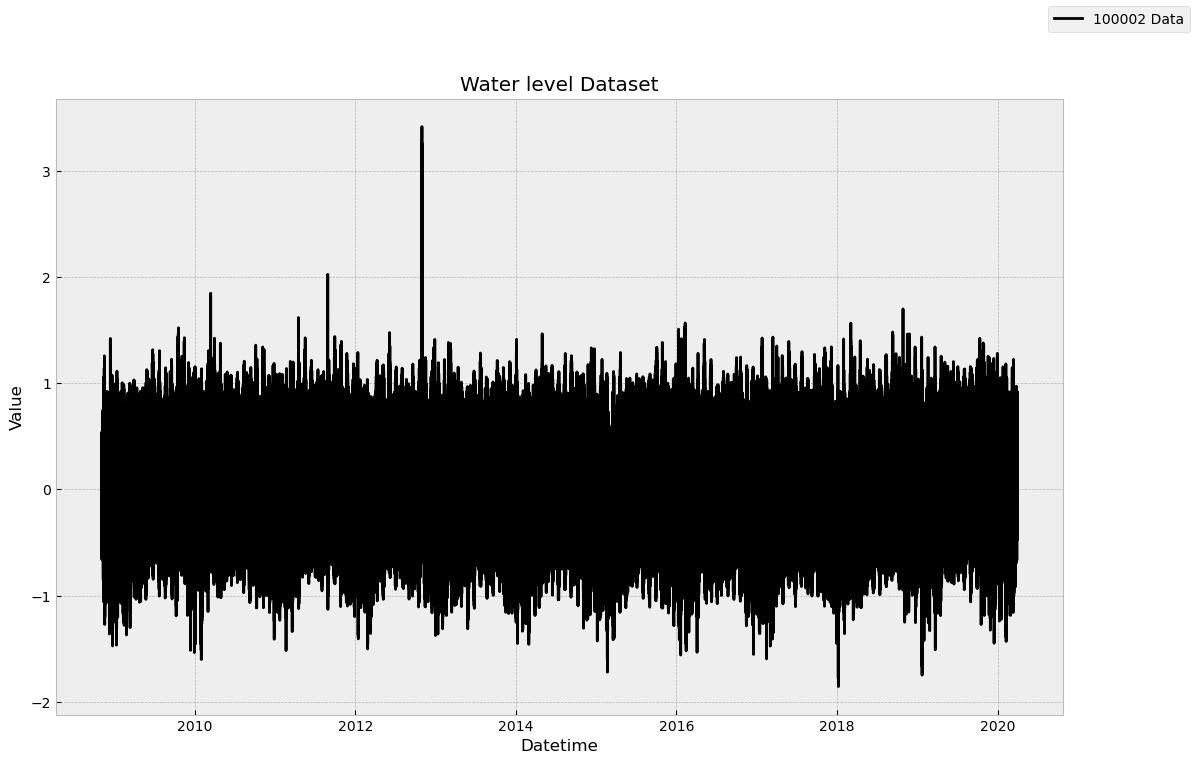

In [34]:
fig = plt.figure(figsize=(13, 8))
plt.plot(ts.index, ts.values, color="black", alpha=1, label=f"{ts.shape[0]} Data")
plt.title(f"{ts.name.capitalize()} Dataset")
plt.xlabel("Datetime")
plt.ylabel("Value")
fig.legend()
plt.show()

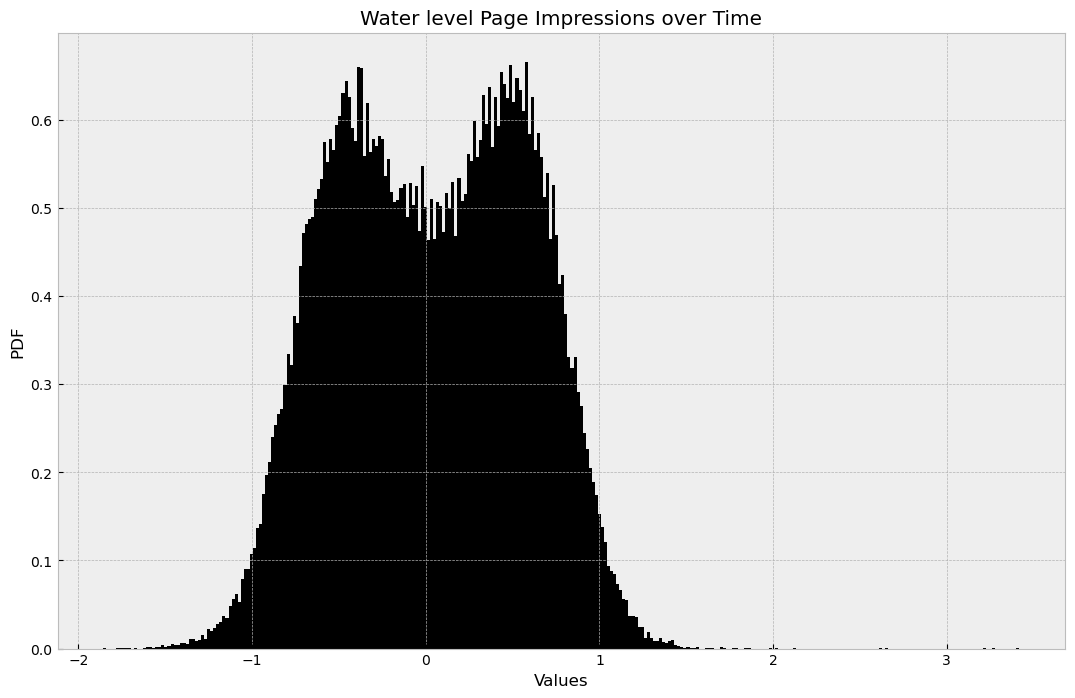

In [33]:
fig = plt.figure(figsize=(13, 8))
plt.hist(ts.values, bins=300, density=True, color="black", alpha=1)
plt.title(f"{ts.name.capitalize()} Page Impressions over Time")
plt.ylabel("PDF")
plt.xlabel("Values")
plt.show()

# **The Detector**

To analyse this data, we are going to apply Peaks Over Threshold method to extract the exceedances and fit it to Generalized Pareto Distribution so we can calculate the anomaly score which is basically just. The idea is to have every statistical method and create a model out of it so we can choose based on the use case. Currently, I  have just implemented the POT Method. Hence the `POT Detector` 😎

In [37]:
pot_detector = atics.get_detector(
    method="POT",
    dataset=ts,
    anomaly_type="high"
)
str(pot_detector)

'POT'

# **The Peaks Over Threshold**

In [43]:
pot_detector.get_extremes(q=0.90)
high_exceedance_threshold_ts = pot_detector.return_dataset(set_type="exceedance_threshold")
high_exceedance_threshold_ts .head(20)

2008-11-03 06:00:00    0.732
2008-11-03 07:00:00    0.732
2008-11-03 08:00:00    0.732
2008-11-03 09:00:00    0.732
2008-11-03 10:00:00    0.732
2008-11-03 11:00:00    0.732
2008-11-03 12:00:00    0.732
2008-11-03 13:00:00    0.732
2008-11-03 14:00:00    0.732
2008-11-03 15:00:00    0.732
2008-11-03 16:00:00    0.732
2008-11-03 17:00:00    0.732
2008-11-03 18:00:00    0.732
2008-11-03 19:00:00    0.732
2008-11-03 20:00:00    0.732
2008-11-03 21:00:00    0.732
2008-11-03 22:00:00    0.732
2008-11-03 23:00:00    0.732
2008-11-04 00:00:00    0.732
2008-11-04 01:00:00    0.732
Name: Water Level, dtype: float64

In [44]:
high_exceedance = pot_detector.return_dataset(set_type="exceedance")
high_exceedance.tail(20)

2020-03-31 04:00:00    0.000
2020-03-31 05:00:00    0.104
2020-03-31 06:00:00    0.127
2020-03-31 07:00:00    0.037
2020-03-31 08:00:00    0.000
2020-03-31 09:00:00    0.000
2020-03-31 10:00:00    0.000
2020-03-31 11:00:00    0.000
2020-03-31 12:00:00    0.000
2020-03-31 13:00:00    0.000
2020-03-31 14:00:00    0.000
2020-03-31 15:00:00    0.000
2020-03-31 16:00:00    0.000
2020-03-31 17:00:00    0.000
2020-03-31 18:00:00    0.000
2020-03-31 19:00:00    0.000
2020-03-31 20:00:00    0.000
2020-03-31 21:00:00    0.000
2020-03-31 22:00:00    0.000
2020-03-31 23:00:00    0.000
Name: exceedances, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


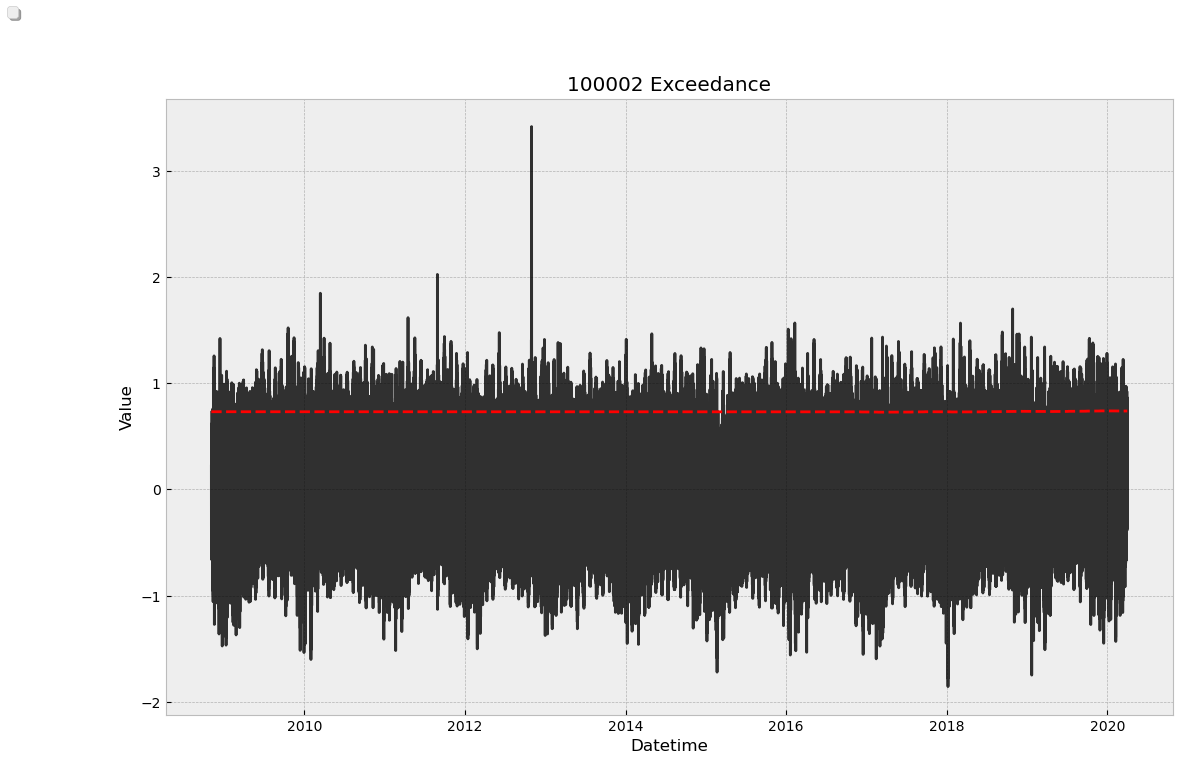

In [46]:
pot_detector.plot(plot_type="l+eth", title=f"{high_exceedance.shape[0]} Exceedance", xlabel="Datetime", ylabel="Value")

# **The Anomaly Score**

The anomaly score is the inverted value which is calculated as follow:

$\text{inverted p-value}=1 / (1-CDF(data, c, loc, scale))$

The idea of the inversion is to give the intuition of how big the score is. 

In [48]:
pot_detector.fit()
high_anomaly_score = pot_detector.return_dataset(set_type="anomaly_score")
high_anomaly_score.head(20)

2016-10-28 22:00:00    0.000000
2016-10-28 23:00:00    0.000000
2016-10-29 00:00:00    0.000000
2016-10-29 01:00:00    0.000000
2016-10-29 02:00:00    0.000000
2016-10-29 03:00:00    0.000000
2016-10-29 04:00:00    0.000000
2016-10-29 05:00:00    0.000000
2016-10-29 06:00:00    0.000000
2016-10-29 07:00:00    0.000000
2016-10-29 08:00:00    0.000000
2016-10-29 09:00:00    0.000000
2016-10-29 10:00:00    0.000000
2016-10-29 11:00:00    0.000000
2016-10-29 12:00:00    1.363639
2016-10-29 13:00:00    1.348931
2016-10-29 14:00:00    0.000000
2016-10-29 15:00:00    0.000000
2016-10-29 16:00:00    0.000000
2016-10-29 17:00:00    0.000000
Name: anomaly scores, dtype: float64

# **The Detection**

This is probably the easiest to implement! But nevertheless, it needed creativity to think about a dynamic way to choose for the threshold. Hence I chose to utilise the quantile method again from `numpy.quantile`. The threshold is calculated only from the `t1` time window.

In [51]:
pot_detector.detect()
high_anomaly = pot_detector.return_dataset(set_type="anomaly")

print("Anomaly threshold:", pot_detector.return_dataset(set_type="anomaly_threshold"))

Anomaly threshold: 10.223334473502508


In [56]:
print("Is today anomaly?", high_anomaly.values[0])

Is today anomaly? False


# **The Evaluation**

In [59]:
pot_detector.evaluate(method="qq")

KeyError: 'datetime'

<Figure size 1500x1000 with 0 Axes>